In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import pandas as pd

In [ ]:
# Download latest version
path_train = "train.csv"
path_test = "test.csv"


# Exploració de les dades


Aquest conjunt de dades inclou descripcions de mostres hipotètiques corresponents a 23 espècies de bolets branquials del bolet de la família Agaricus i Lepiota extretes de The Audubon Society Field Guide to North American Mushrooms. Cada espècie s'identifica com a definitivament comestible, definitivament verinosa o de comestibilitat desconeguda i no recomanada. Aquesta darrera classe es va combinar amb la verinosa.

La Guia diu clarament que no hi ha una regla senzilla per determinar la comestibilitat d'un bolet, per tant, intentarem trobar el millor model que pugui classificar els bolets en comestibles o no comestibles a partir de les seves característiques.

In [ ]:
# Load CSV file into DataFrame
train_orig = pd.read_csv(path_train)
df = train_orig.copy()

del train_orig


l primer que farem sera eliminar la columna ID, la qual no ens aportara cap informació útil, ja que només és un valor incremental diferent per a cada fila, no dona informació del bolet.

In [ ]:
df = df.drop('id', axis=1)
print(df.shape)
print(df.dtypes)


(3116945, 21)
class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object


A primera vista, tenim un dataset amb 3116945 exemplars pel train i 20 característiques.

aracterístiques nominals:

* class: classe (per exemple, comestible o tòxica)
* cap-shape: forma del barret
* cap-surface: superfície del barret
* cap-color: color del barret
* does-bruise-or-bleed: presència de marques/morellia o sagnat
* gill-attachment: adhesió de les làmines
* gill-color: color de les làmines
* stem-root: tipus de base del peu
* ring-type: tipus d'anell
* stem-surface: superfície del peu
* stem-color: color del peu
* veil-type: tipus de vel
* veil-color: color del vel
* gill-spacing: espaiament de les làmines
* has-ring: presència d'anell
* spore-print-color: color de l'empremta de les espores
* habitat: hàbitat
* season: estació de l'any

Característiques quantitatives (numèriques):

* cap-diameter: diàmetre del barret
* stem-height: alçada del peu
* stem-width: amplada del peu


Necesitem també calcular la quantitat de NaNs que conte el nostre dataset, i més endevant haurem de decidir com tractar-los per obtenir els millors resultats. Ja sigui eliminar tota fila amb NaNs, la columna sencera si té un alt percentatge o reomplir els valors amb alguna tecnica com la mitja en cas de valors

In [ ]:
print(f"NaNs al dataset: ", df.isna().sum().sum())

NaNs al dataset:  9238625


Aquest dataset conte molts NaNs, més endevant sera necesari tractar amb ells d'alguna manera per poder millorar els resultats.

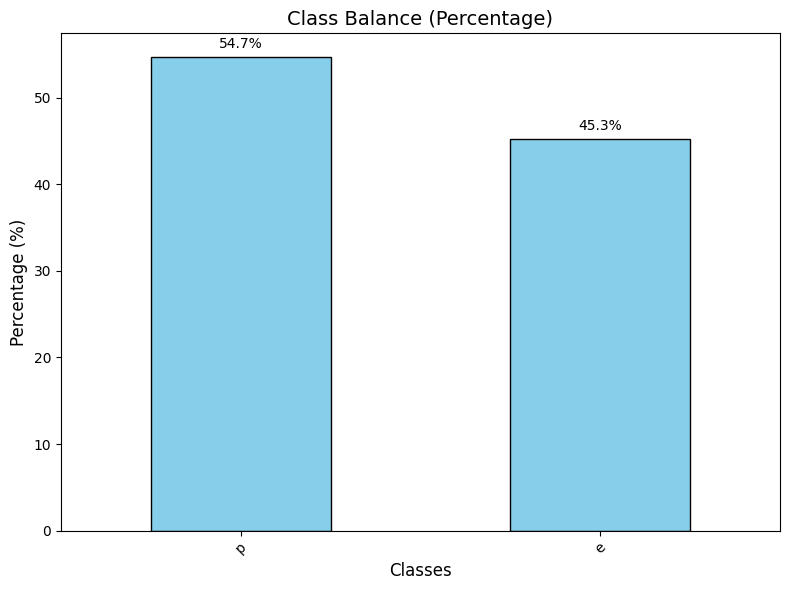

In [ ]:
#a eliminar es fa el mateix més abaix
class_percentages = df['class'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
bars = class_percentages.plot(kind='bar', color='skyblue', edgecolor='black')

for i, percentage in enumerate(class_percentages):
    plt.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', fontsize=10)
plt.title('Class Balance (Percentage)', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
plt.close()

Per seguir explorant les dades comprobarem com estan distribuits els atributs en cada classe i quins són els diferents valors que contenen.

In [ ]:
object_columns = [col for col in df.columns if df[col].dtype == 'object']
numeric_columns = [col for col in df.columns if df[col].dtype == 'float64']

for column in object_columns:
    print(column)
    print(df[column].unique())


class
['e' 'p']
cap-shape
['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' '19.29' '5 f' 't'
 'g' 'z' 'a' '2.85' '7 x' 'r' 'u' '3.55' 'is s' 'y' '4.22' '3.6' '21.56'
 'i' '6 x' '24.16' '8' 'm' 'ring-type' '10.13' 'is p' '7.43' 'h' '0.82'
 '10.46' '2.77' '2.94' '12.62' '5.15' '19.04' '4.97' '49.21' 'b f' '9.13'
 '1.66' '3.37' '7.21' '3.25' '11.12' '3 x' '4.3' '7.41' '6.21' '8.29'
 '54.78' '20.25' '3.52' '3.04' '2.63' '3.91' '6.44' '8.3' '7.6' '17.44'
 '4.33' '2.82' '6.53' '19.06']
cap-surface
['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k' '15.94' 'f' 'n' 'r' 'o'
 'a' 'u' 'z' '2.7' 'does l' '5.07' 'p' 'b' 'm' 'cap-diameter' '1.43' 'x'
 '7.14' 'c' 'is h' 'does t' '0.85' '6.57' '12.79' '6.45' '4.66' '23.18'
 '3.06' '16.39' '4.21' 'veil-color' '11.78' '8.1' 'has-ring' 'does h'
 '1.42' 'class' 'has h' 'does None' '10.83' 'season' '8.96' '14.04' '5.73'
 'is None' '24.38' '2.81' '0.88' '2.11' '2.79' 'ring-type'
 'does-bruise-or-bleed' '4.93' 'spore-print-color' 'spore-color' '2.92'
 

In [ ]:
df.nunique()

,0
class,2
cap-diameter,3680
cap-shape,53
cap-surface,65
cap-color,57
does-bruise-or-bleed,24
gill-attachment,56
gill-spacing,35
gill-color,54
stem-height,2639


Aquest dataset sembla estar molt brut, tenim molts valors anòmals en les variables categòriques amb valors que no tenen sentit generant una quantitat molt gran de classes, per exemple en la categoria 'habitat' tenim com a atributs els valors 8.09, 9.28, 'does-bruise-or-bleed', etc. Totes les característiques categòriques sembla que segueixen el mateix patró. Eliminarem els valors que siguin numèrics o que no tinguin sentit, per fer-ho, ens quedarem només amb classes que continguin 1 lletra.

In [ ]:
filtered_df = df
for col in object_columns:
  if col in filtered_df.columns:
    filtered_df[col] = filtered_df[col].where(filtered_df[col].astype(str).str.match(r'^[a-zA-Z]$'))
for column in object_columns:
    print(column)
    print(filtered_df[column].unique())
print(filtered_df.shape)

class
['e' 'p']
cap-shape
['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' 't' 'g' 'z' 'a'
 'r' 'u' 'y' 'i' 'm' 'h']
cap-surface
['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k' 'f' 'n' 'r' 'o' 'a' 'u'
 'z' 'p' 'b' 'm' 'x' 'c']
cap-color
['u' 'o' 'b' 'g' 'w' 'n' 'e' 'y' 'r' 'p' 'k' 'l' 'i' 'h' 'd' 's' 'a' 'f'
 nan 'c' 'x' 'm' 'z' 't']
does-bruise-or-bleed
['f' 't' 'd' nan 'w' 'o' 'b' 'x' 'p' 'g' 'y' 'r' 'a' 'l' 'i' 'c' 'n' 'z'
 's' 'k' 'h' 'e' 'u']
gill-attachment
['a' 'x' 's' 'd' 'e' nan 'f' 'p' 'l' 'm' 'b' 'n' 'g' 'i' 'u' 't' 'o' 'c'
 'w' 'k' 'r' 'h' 'z' 'y']
gill-spacing
['c' nan 'd' 'f' 'x' 'b' 'a' 'k' 'e' 'y' 's' 'p' 't' 'i' 'w' 'h' 'l' 'r'
 'n' 'g']
gill-color
['w' 'n' 'g' 'k' 'y' 'f' 'p' 'o' 'b' 'u' 'e' 'r' 'd' 't' nan 'z' 'h' 'x'
 's' 'c' 'm' 'l' 'a' 'i']
stem-root
[nan 'b' 'c' 'r' 's' 'f' 'y' 'o' 'k' 'd' 'n' 'w' 'u' 'p' 'x' 'i' 'a' 't'
 'm' 'l' 'h' 'g' 'e' 'z']
stem-surface
[nan 'y' 's' 't' 'g' 'h' 'k' 'i' 'f' 'l' 'd' 'x' 'w' 'a' 'o' 'c' 'n' 'm'
 'e' 'p' 'z' 'b' 'r' 'u

In [ ]:
filtered_df.nunique()

,0
class,2
cap-diameter,3913
cap-shape,23
cap-surface,23
cap-color,23
does-bruise-or-bleed,22
gill-attachment,23
gill-spacing,19
gill-color,23
stem-height,2749


Despres de passar aquest filtre veiem com s'han reduït molt el nombre de classes diferents en cada caracteristica, a excepció de les caracteristiques numeriques "cap-diameter", "stem-height" i "stem-width".

# Anàlisis de variables categòriques (nominals i ordinals)

Una part molt important en el analisis de dades es saber com estan distribuides les dades en el nostre dataset, que la caracterisitica a analitzar estigui o no balancejada fara que algunes metriques com el 'Acuracy' siguin practicament inutilitzables. Per tant necesitem saber aquestra distribució per a avaluar correctament els nostres classificadors.

Farem també un analisi de totes les caracteristiques despres del filtre per veure si estan molt descompensades, per saber si s'utilitzen totes les classes o només s'usen dues i la resta nomes estan repetides unes poques vegades.


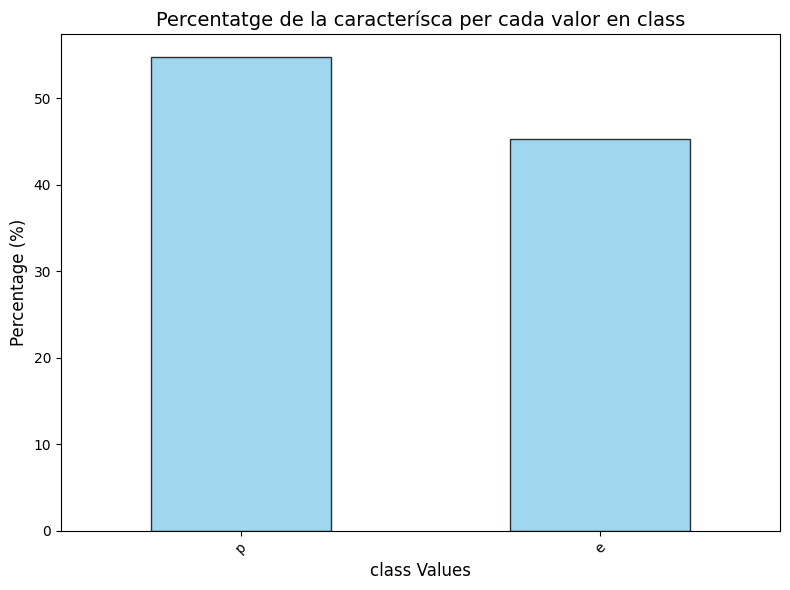

class
p    54.713702
e    45.286298
Name: proportion, dtype: float64



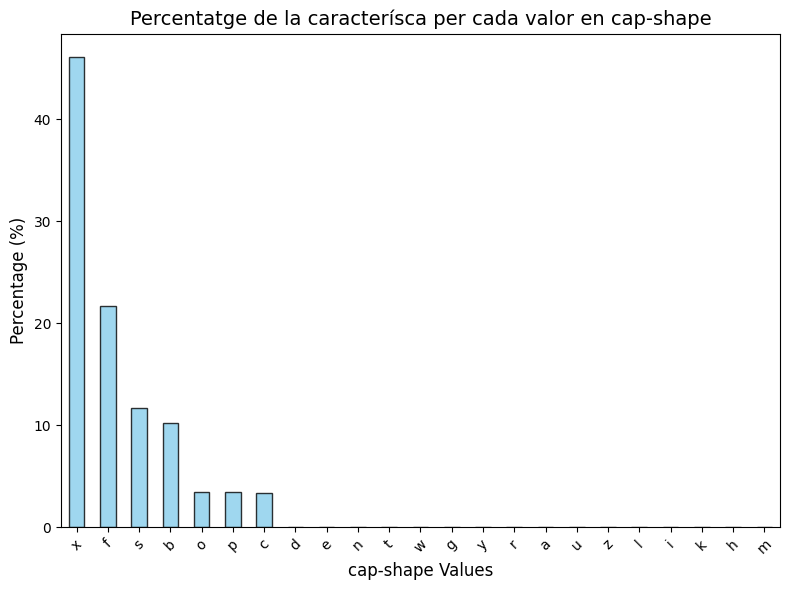

cap-shape
x    46.072990
f    21.696200
s    11.715225
b    10.223334
o     3.491827
p     3.431894
c     3.353386
d     0.002085
e     0.001925
n     0.001315
t     0.001155
w     0.001155
g     0.001091
y     0.001059
r     0.001027
a     0.000963
u     0.000866
z     0.000706
l     0.000674
i     0.000449
k     0.000417
h     0.000193
m     0.000064
Name: proportion, dtype: float64



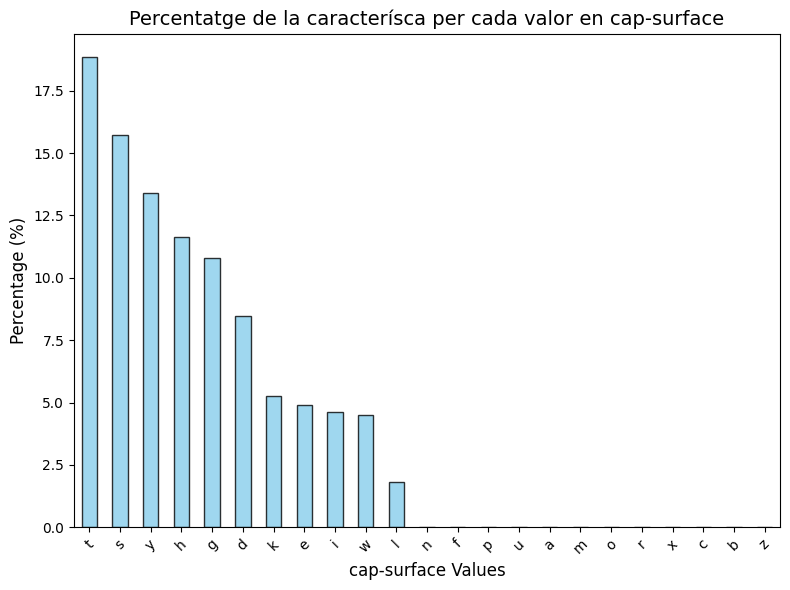

cap-surface
t    18.839143
s    15.739729
y    13.403362
h    11.630317
g    10.782718
d     8.456450
k     5.269131
e     4.894497
i     4.638062
w     4.490874
l     1.834087
n     0.003925
f     0.003066
p     0.002412
u     0.002003
a     0.001799
m     0.001717
o     0.001595
r     0.001431
x     0.001349
c     0.001267
b     0.000736
z     0.000327
Name: proportion, dtype: float64



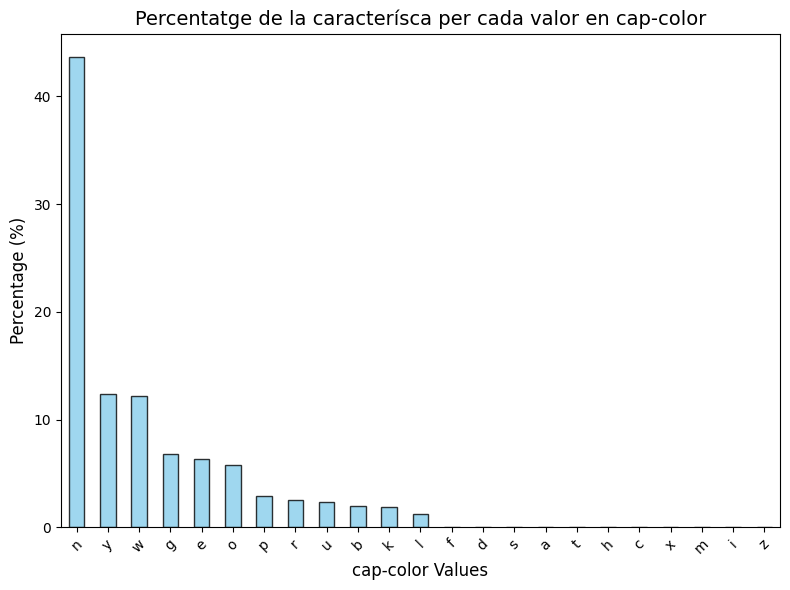

cap-color
n    43.618949
y    12.404371
w    12.173851
g     6.764017
e     6.329766
o     5.738049
p     2.946490
r     2.510089
u     2.347618
b     1.967139
k     1.921420
l     1.269162
f     0.001700
d     0.001540
s     0.001251
a     0.000963
t     0.000834
h     0.000706
c     0.000449
x     0.000449
m     0.000449
i     0.000417
z     0.000321
Name: proportion, dtype: float64



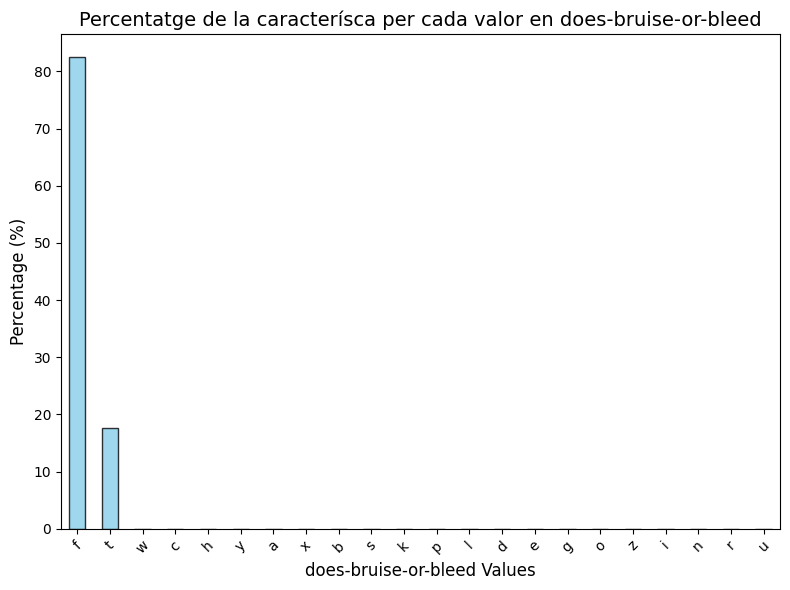

does-bruise-or-bleed
f    82.444602
t    17.552030
w     0.000449
c     0.000353
h     0.000289
y     0.000225
a     0.000225
x     0.000225
b     0.000225
s     0.000192
k     0.000192
p     0.000128
l     0.000128
d     0.000128
e     0.000128
g     0.000096
o     0.000096
z     0.000096
i     0.000064
n     0.000064
r     0.000032
u     0.000032
Name: proportion, dtype: float64



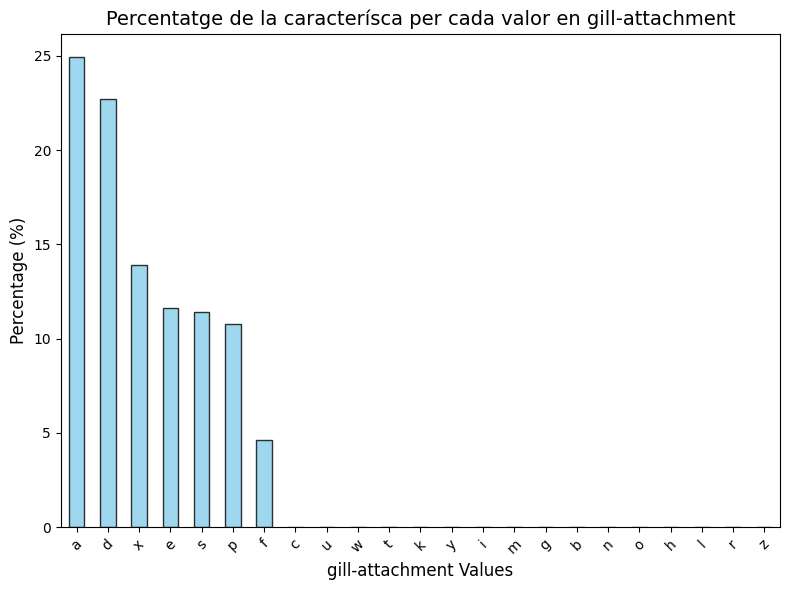

gill-attachment
a    24.915029
d    22.724550
x    13.917667
e    11.641494
s    11.393938
p    10.764192
f     4.626123
c     0.002854
u     0.002160
w     0.001427
t     0.001388
k     0.001273
y     0.001080
i     0.000964
m     0.000848
g     0.000848
b     0.000810
n     0.000771
o     0.000694
h     0.000694
l     0.000617
r     0.000386
z     0.000193
Name: proportion, dtype: float64



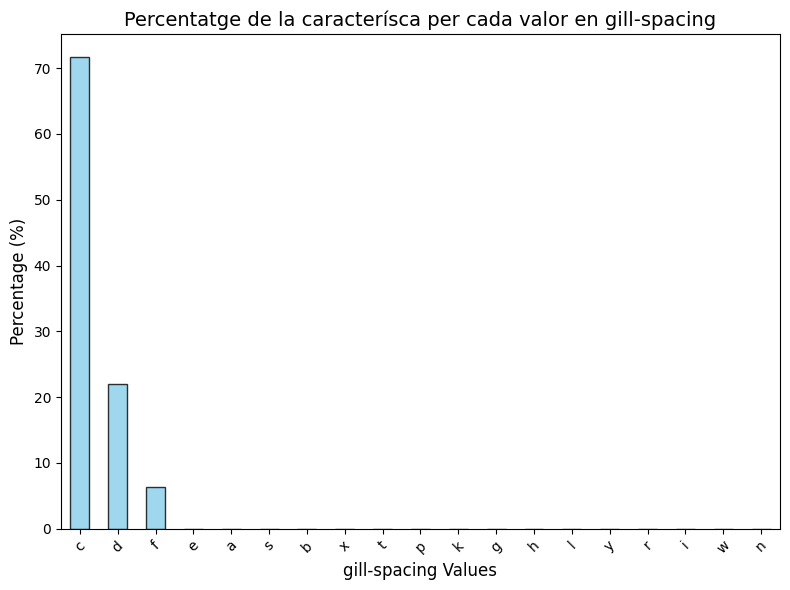

gill-spacing
c    71.620610
d    21.949777
f     6.423532
e     0.001291
a     0.000915
s     0.000861
b     0.000646
x     0.000430
t     0.000430
p     0.000377
k     0.000215
g     0.000215
h     0.000161
l     0.000161
y     0.000108
r     0.000108
i     0.000054
w     0.000054
n     0.000054
Name: proportion, dtype: float64



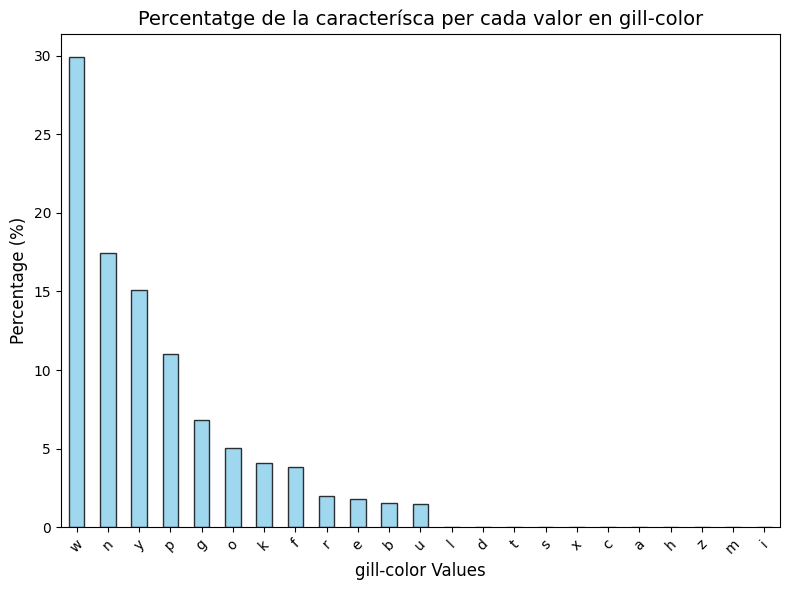

gill-color
w    29.887440
n    17.433982
y    15.062270
p    11.024887
g     6.807064
o     5.041002
k     4.105786
f     3.840259
r     2.014841
e     1.798210
b     1.515871
u     1.456580
l     0.001765
d     0.001733
t     0.001733
s     0.001476
x     0.001123
c     0.000995
a     0.000898
h     0.000770
z     0.000513
m     0.000513
i     0.000289
Name: proportion, dtype: float64



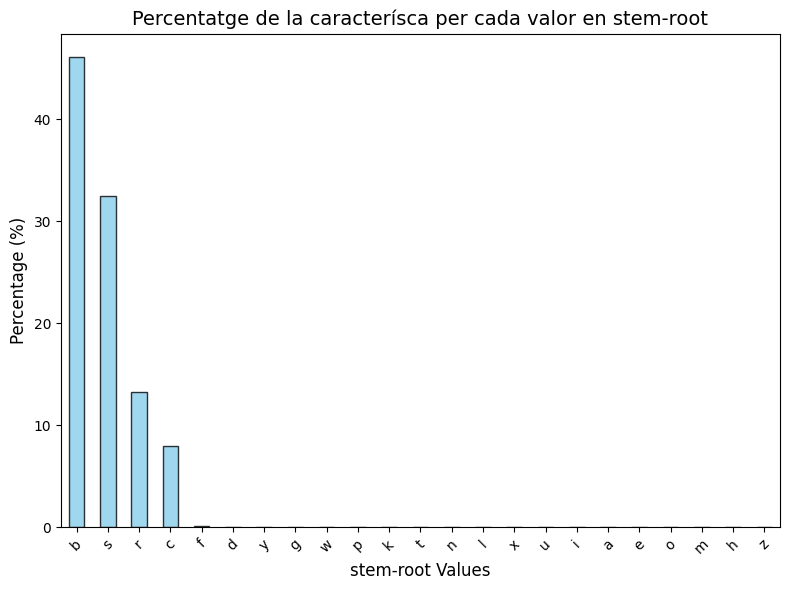

stem-root
b    46.067734
s    32.493394
r    13.282042
c     7.944274
f     0.165876
d     0.006668
y     0.003890
g     0.003334
w     0.003334
p     0.003334
k     0.003056
t     0.002778
n     0.002778
l     0.002778
x     0.002501
u     0.002223
i     0.002223
a     0.001945
e     0.001667
o     0.001389
m     0.001111
h     0.001111
z     0.000556
Name: proportion, dtype: float64



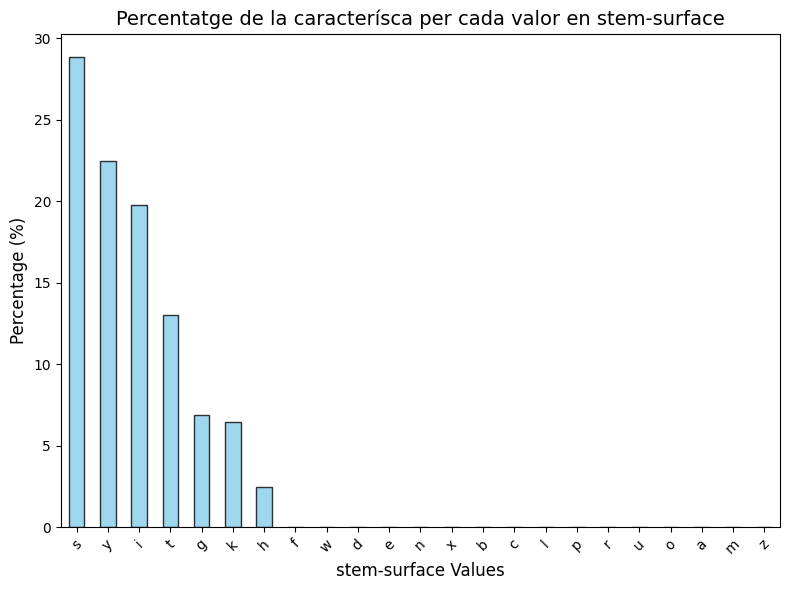

stem-surface
s    28.837969
y    22.490465
i    19.748124
t    13.025456
g     6.873016
k     6.459561
h     2.489620
f     0.045069
w     0.004313
d     0.004225
e     0.003169
n     0.002993
x     0.002289
b     0.002025
c     0.001937
l     0.001761
p     0.001761
r     0.001761
u     0.001408
o     0.001320
a     0.000968
m     0.000616
z     0.000176
Name: proportion, dtype: float64



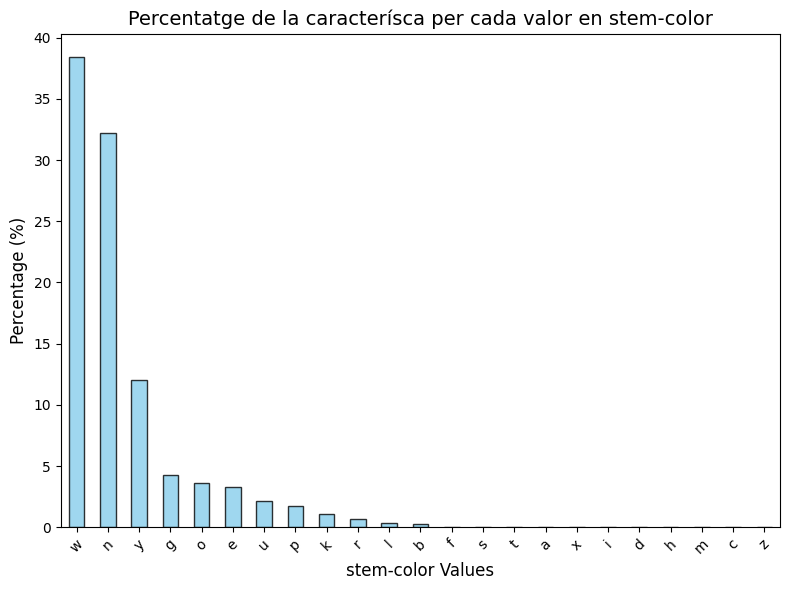

stem-color
w    38.392302
n    32.194636
y    11.998298
g     4.235631
o     3.578626
e     3.316568
u     2.150140
p     1.754647
k     1.080444
r     0.716392
l     0.320642
b     0.236295
f     0.018384
s     0.001636
t     0.001283
a     0.001155
x     0.000642
i     0.000610
d     0.000513
h     0.000385
m     0.000353
c     0.000225
z     0.000193
Name: proportion, dtype: float64



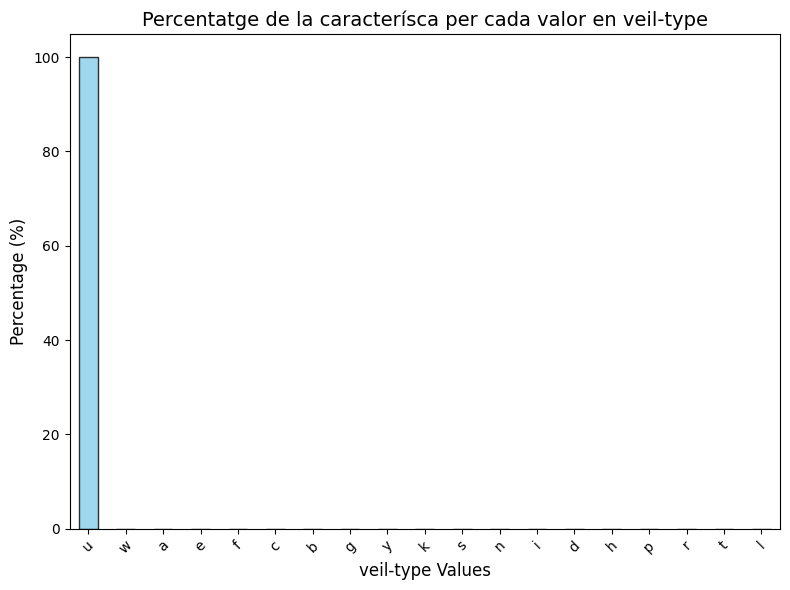

veil-type
u    99.952336
w     0.006899
a     0.005644
e     0.005017
f     0.005017
c     0.003136
b     0.003136
g     0.002509
y     0.002509
k     0.002509
s     0.001881
n     0.001881
i     0.001254
d     0.001254
h     0.001254
p     0.001254
r     0.001254
t     0.000627
l     0.000627
Name: proportion, dtype: float64



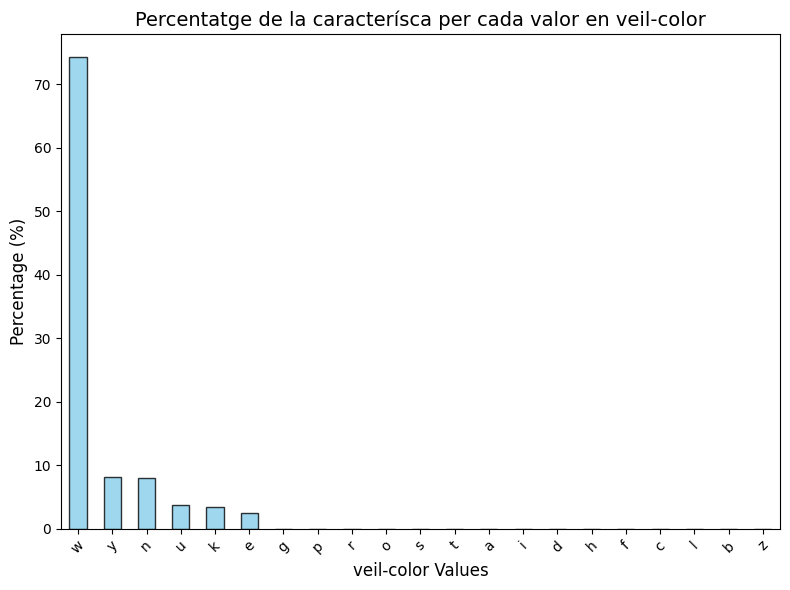

veil-color
w    74.221732
y     8.104629
n     7.989202
u     3.730369
k     3.478770
e     2.438596
g     0.007979
p     0.006117
r     0.003723
o     0.003457
s     0.002926
t     0.001862
a     0.001862
i     0.001596
d     0.001596
h     0.001330
f     0.001064
c     0.001064
l     0.001064
b     0.000798
z     0.000266
Name: proportion, dtype: float64



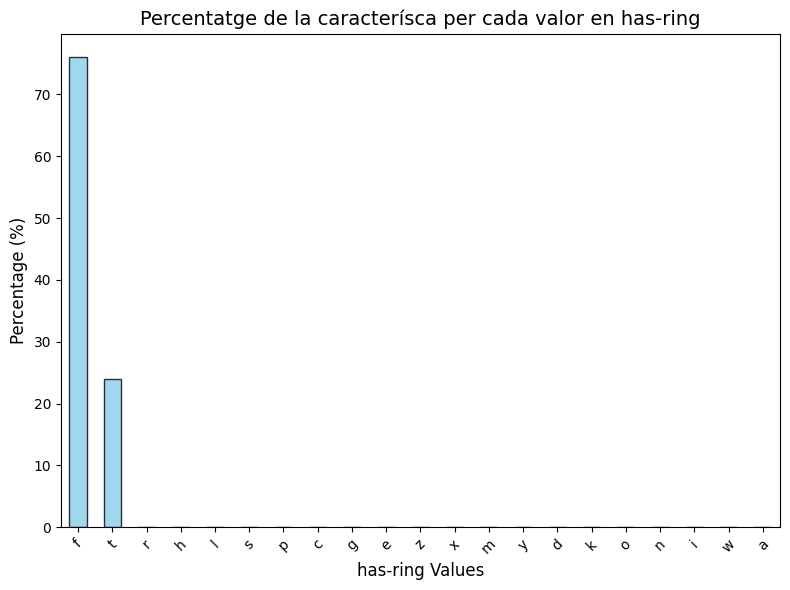

has-ring
f    75.998767
t    23.997480
r     0.000513
h     0.000417
l     0.000353
s     0.000353
p     0.000353
c     0.000353
g     0.000257
e     0.000192
z     0.000192
x     0.000160
m     0.000128
y     0.000096
d     0.000096
k     0.000064
o     0.000064
n     0.000064
i     0.000032
w     0.000032
a     0.000032
Name: proportion, dtype: float64



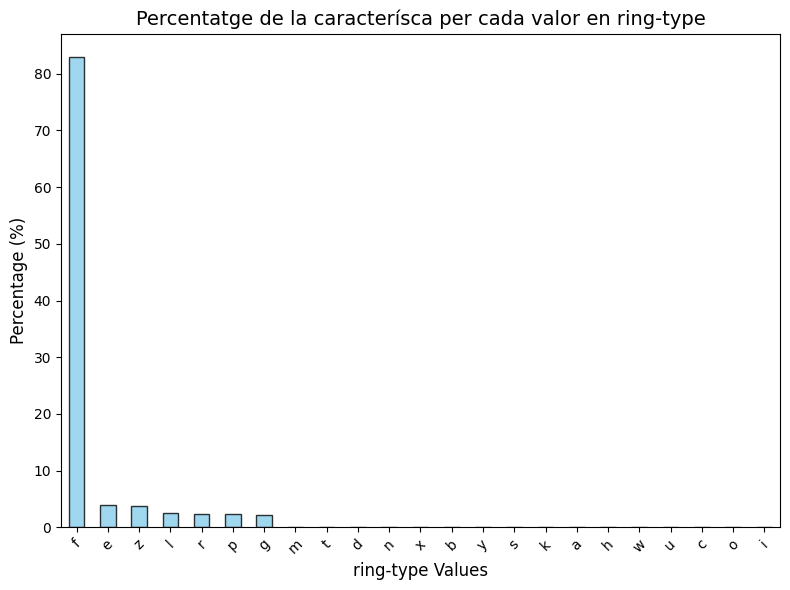

ring-type
f    82.902895
e     4.016214
z     3.807850
l     2.457900
r     2.272695
p     2.264965
g     2.131399
m     0.133599
t     0.003280
d     0.001238
n     0.001138
x     0.001071
b     0.000971
y     0.000837
s     0.000602
k     0.000602
a     0.000535
h     0.000502
w     0.000469
u     0.000435
c     0.000368
o     0.000301
i     0.000134
Name: proportion, dtype: float64



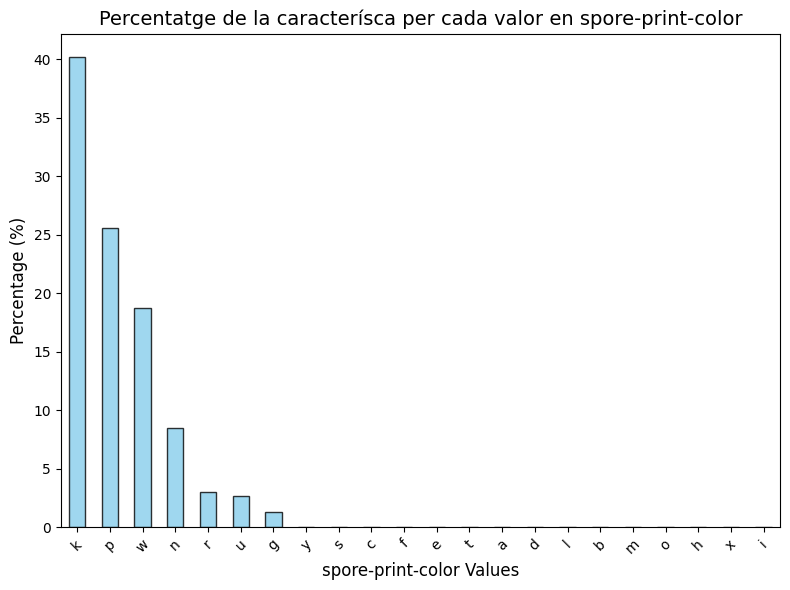

spore-print-color
k    40.153114
p    25.532830
w    18.773667
n     8.473650
r     2.984075
u     2.715040
g     1.306632
y     0.013470
s     0.007858
c     0.005987
f     0.005239
e     0.005239
t     0.004864
a     0.004864
d     0.003368
l     0.002993
b     0.001871
m     0.001497
o     0.001123
h     0.001123
x     0.000748
i     0.000748
Name: proportion, dtype: float64



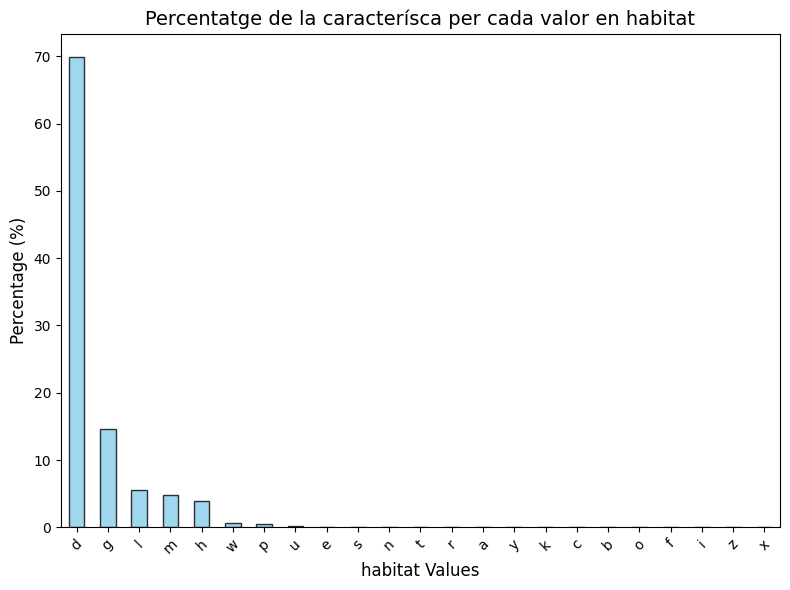

habitat
d    69.864274
g    14.595064
l     5.514906
m     4.843622
h     3.854422
w     0.594508
p     0.551195
u     0.168888
e     0.001765
s     0.001668
n     0.001315
t     0.001283
r     0.001219
a     0.001091
y     0.001091
k     0.000995
c     0.000834
b     0.000578
o     0.000385
f     0.000353
i     0.000225
z     0.000160
x     0.000160
Name: proportion, dtype: float64



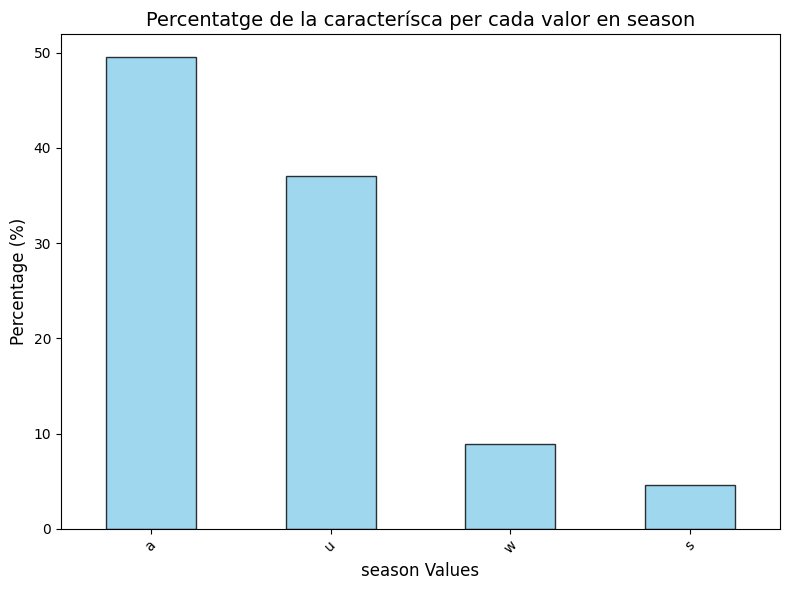

season
a    49.513899
u    37.010214
w     8.925053
s     4.550834
Name: proportion, dtype: float64



In [ ]:
def plot_characteristic_percentages(df):
    for col in object_columns:
        if col in df.columns and col != 'class':
            value_counts = df[col].value_counts(normalize=True) * 100

            plt.figure(figsize=(8, 6))
            value_counts.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.8)
            plt.title(f'Percentatge de la caracterísca per cada valor en {col}', fontsize=14)
            plt.xlabel(f'{col} Values', fontsize=12)
            plt.ylabel('Percentage (%)', fontsize=12)
            plt.xticks(rotation=45, fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()
            print(value_counts)
            print("")

plot_characteristic_percentages(filtered_df)
plt.close()

Podem veure que els valors de cada característica en la majoria es concentren en poques classes.

També podem veure que la caracteristica a analitzar es força balancejada, aixó ens permetra l'ús de practicament totes les metriques d'avaluació de classificadors, ja que no ni ha cap que surti fortament desafavorida.

# Anàlisis de les característiques numèriques

En les característiques contínues farem una anàlisi per veure com estan distribuïdes i si haurem d'eliminar valors anòmals abans de normalitzar.

In [ ]:
pd.set_option('display.float_format', '{:.4f}'.format)
print(filtered_df.describe())

       cap-diameter  stem-height   stem-width
count  3116941.0000 3116945.0000 3116945.0000
mean         6.3098       6.3483      11.1538
std          4.6579       2.6998       8.0955
min          0.0300       0.0000       0.0000
25%          3.3200       4.6700       4.9700
50%          5.7500       5.8800       9.6500
75%          8.2400       7.4100      15.6300
max         80.6700      88.7200     102.9000


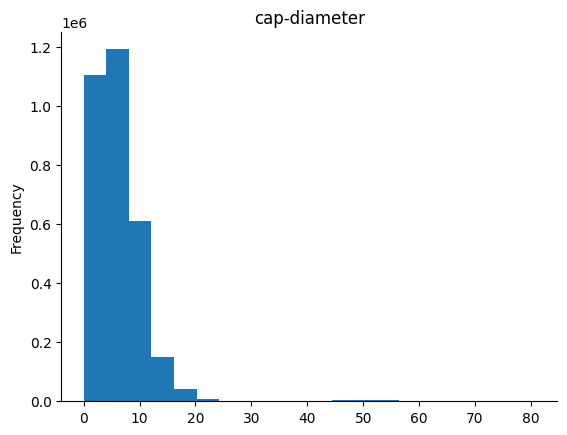

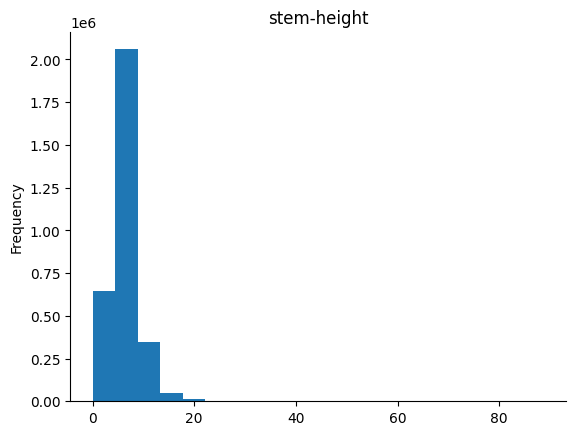

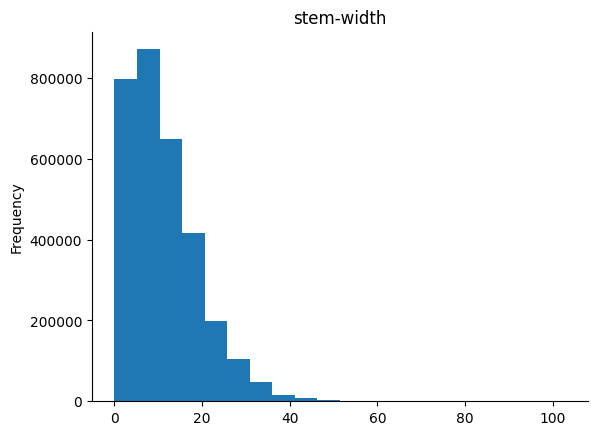

In [ ]:
for col in numeric_columns:
    filtered_df[col].plot(kind='hist', bins=20, title=col)
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()
    print("")

En els tres casos la majoria de valors es concentren al principi, però la grafica arriba molt més enllà, aixó ens indica que tenim uns pocs valors en el extrem dret que ens modificaran molt la normalització, aquets valors anomals els haurem de tractar.

# Relació de les variables categòriques amb el target

Per buscar les relacions entre les variables categoriques i el target mostrarem una serie de grafics on indicarem el percentatge dels valors que pertanyen a cada una de les classes objectiu "e" i "p", si aquest percentatge és proper al 50% llavors no ens dona cap informació, en canvi els percentatges més extrems ens indicaran que si te aquell atribut és més facil assegurar a quina classe pertany.

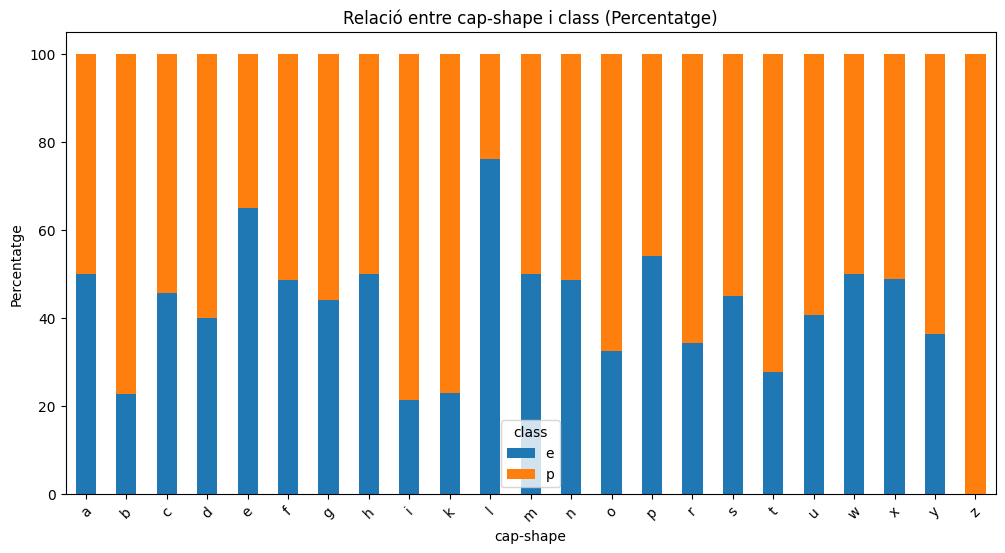

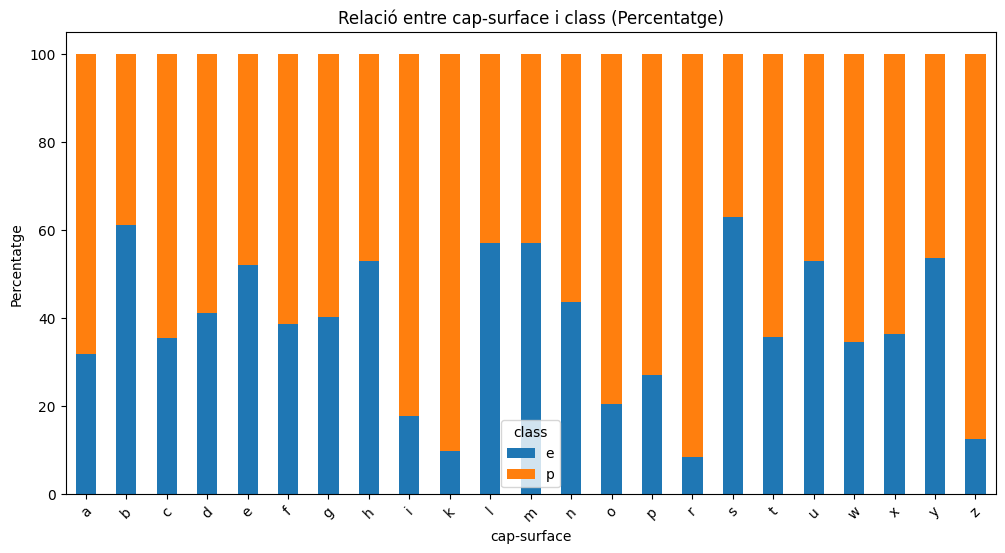

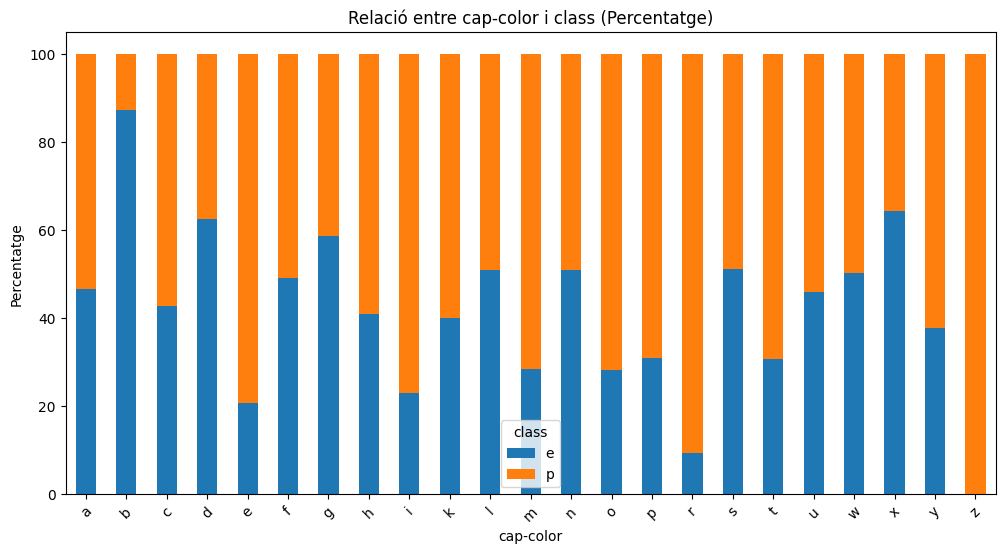

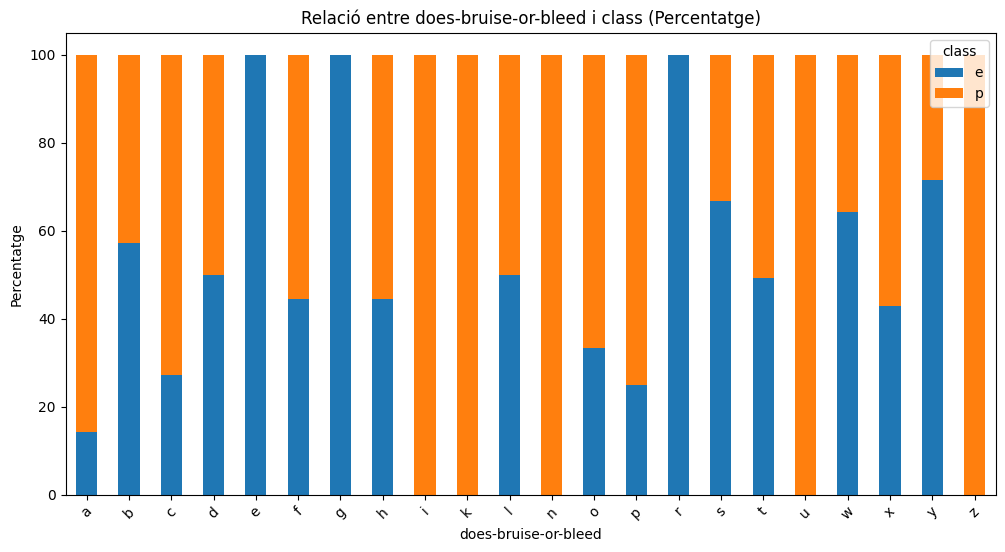

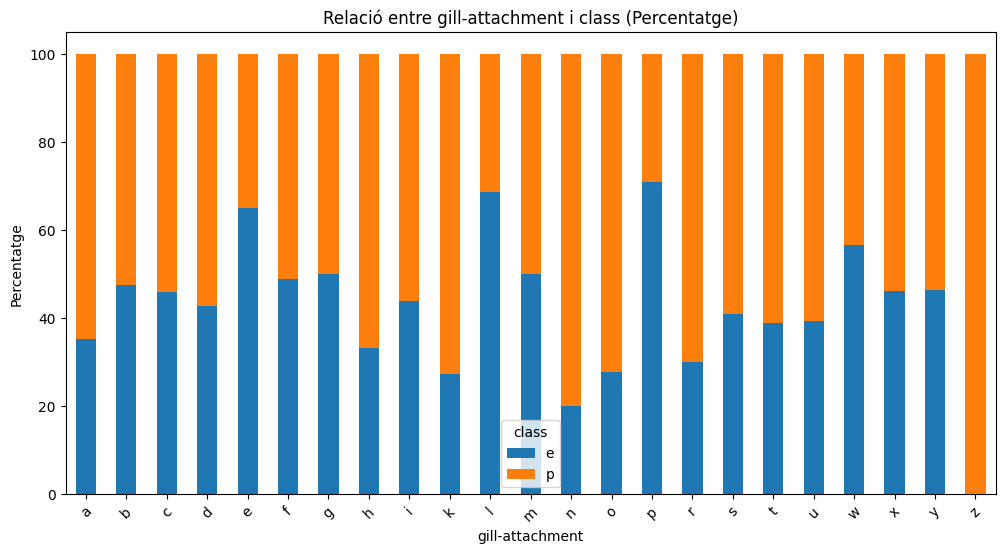

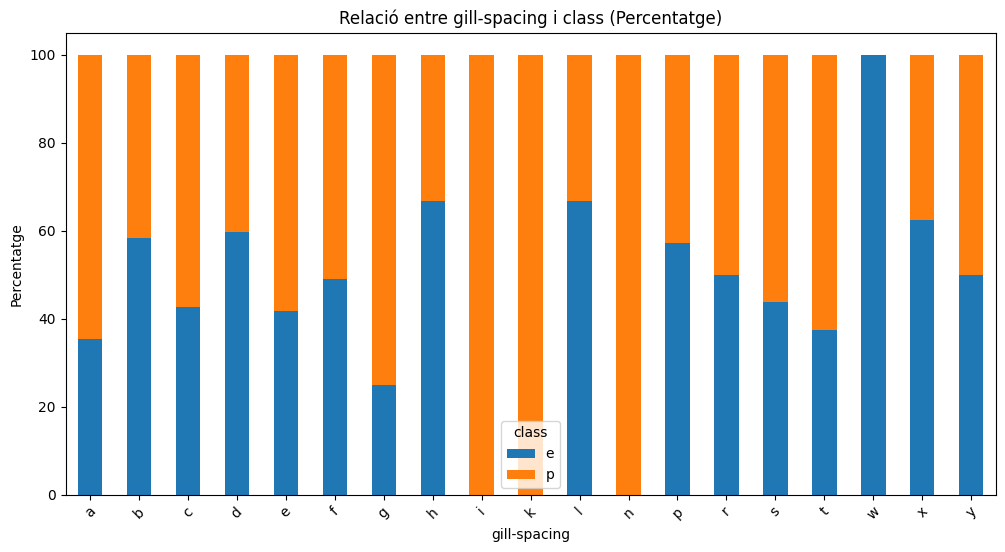

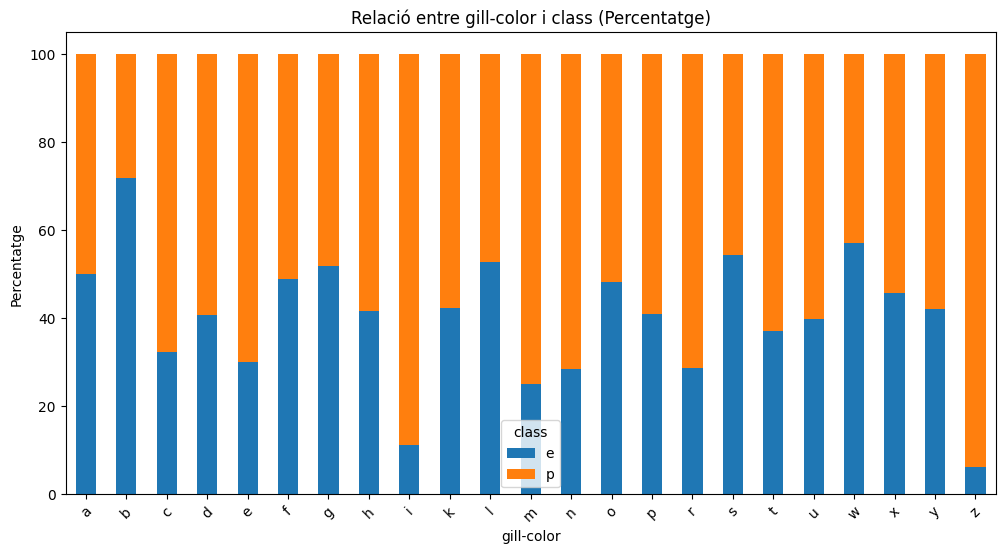

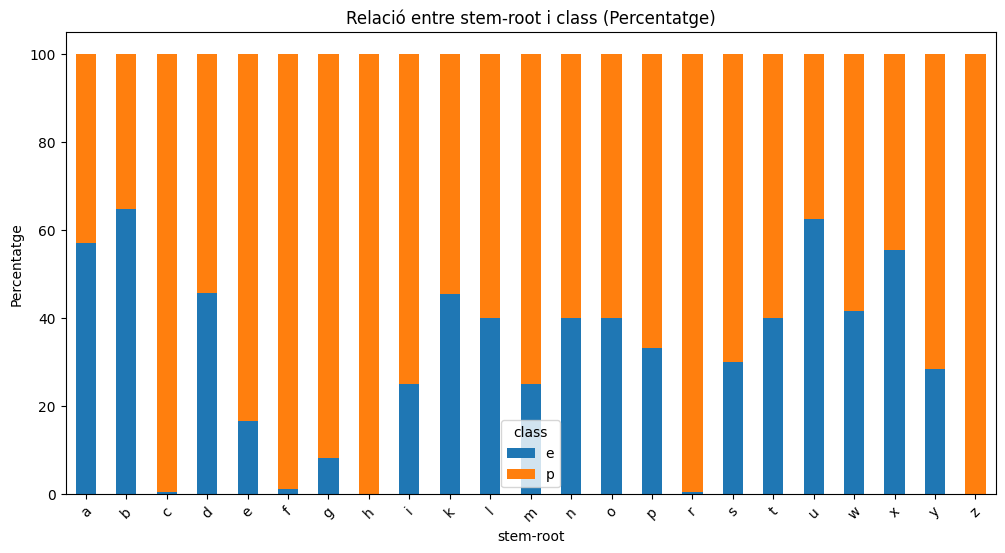

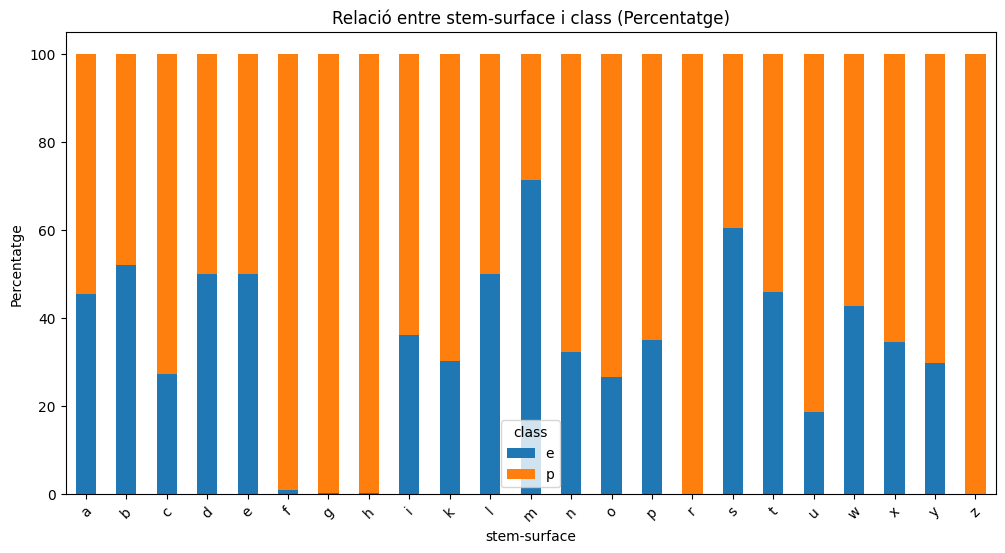

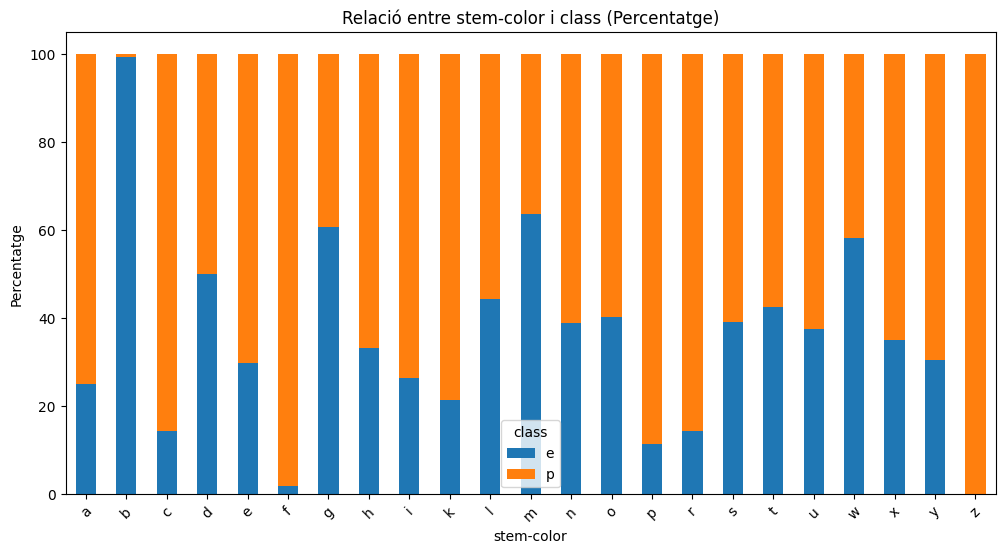

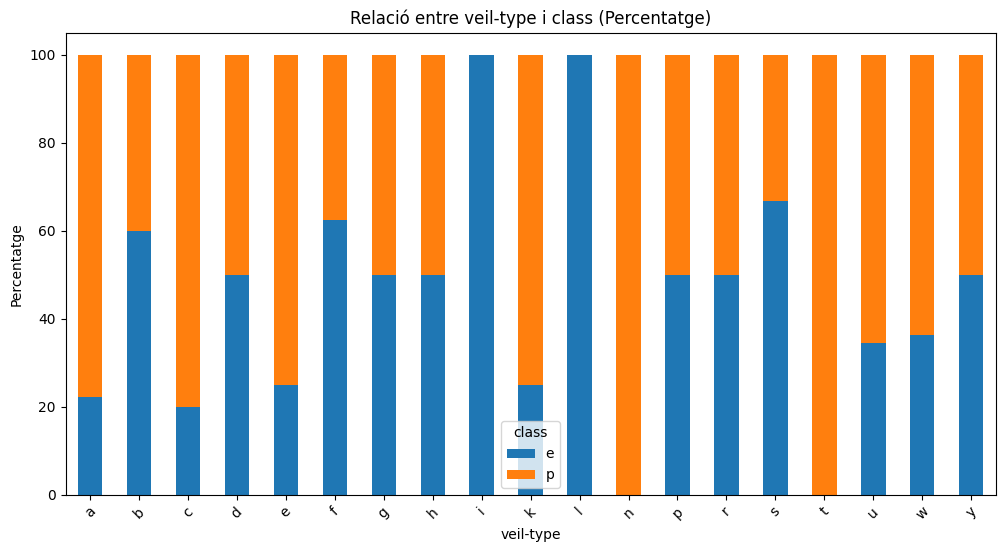

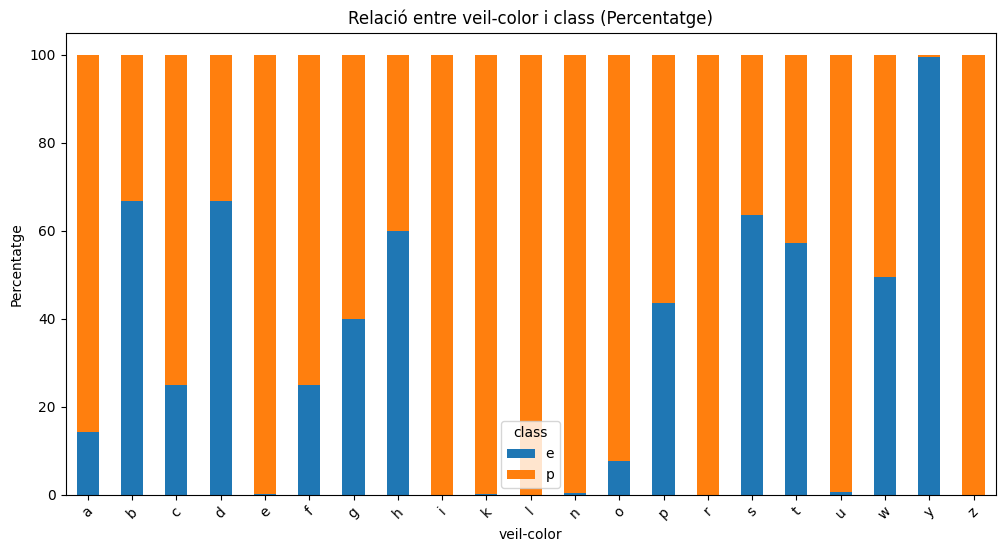

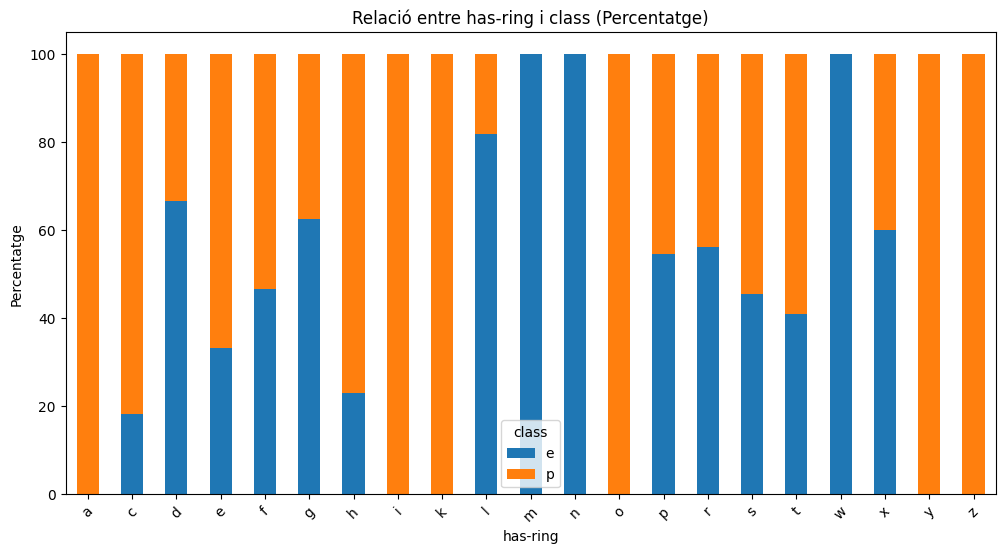

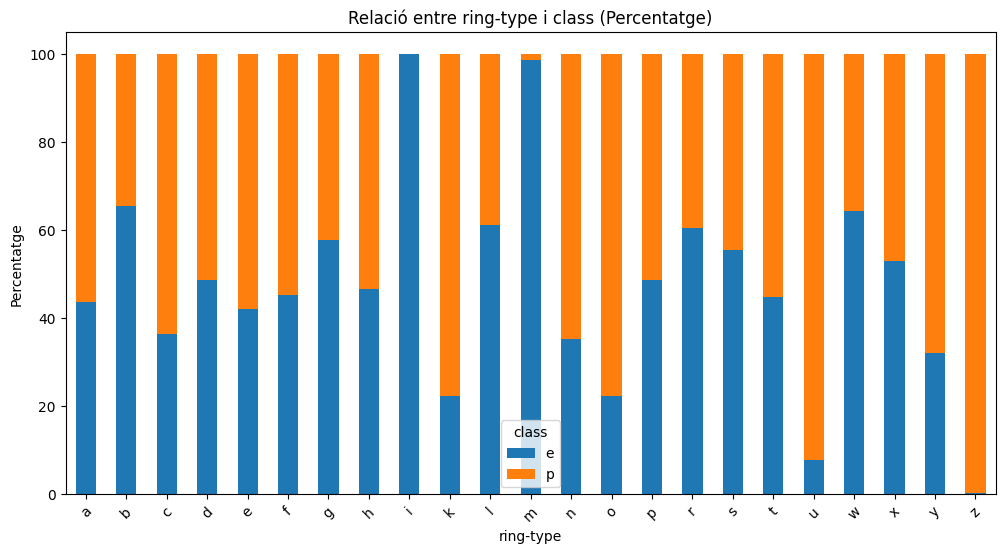

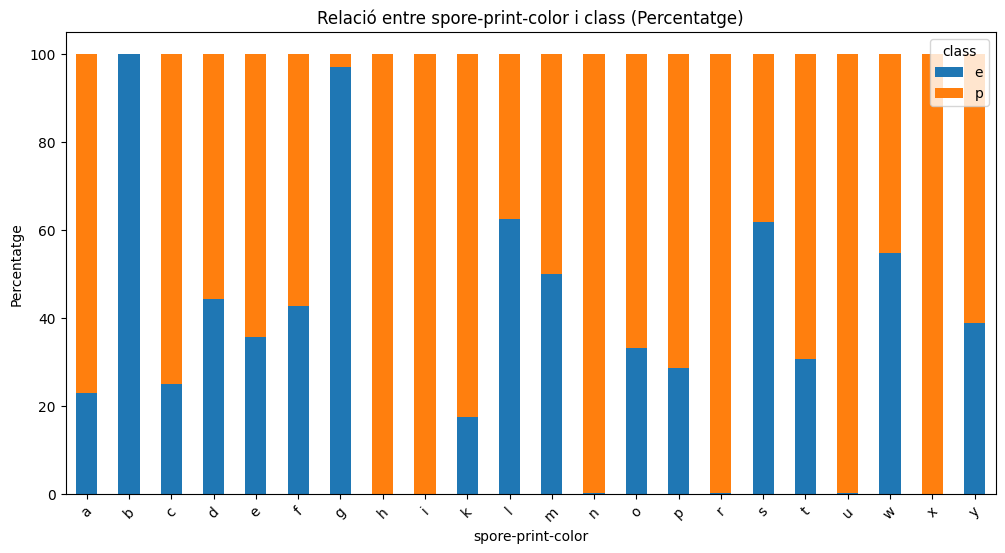

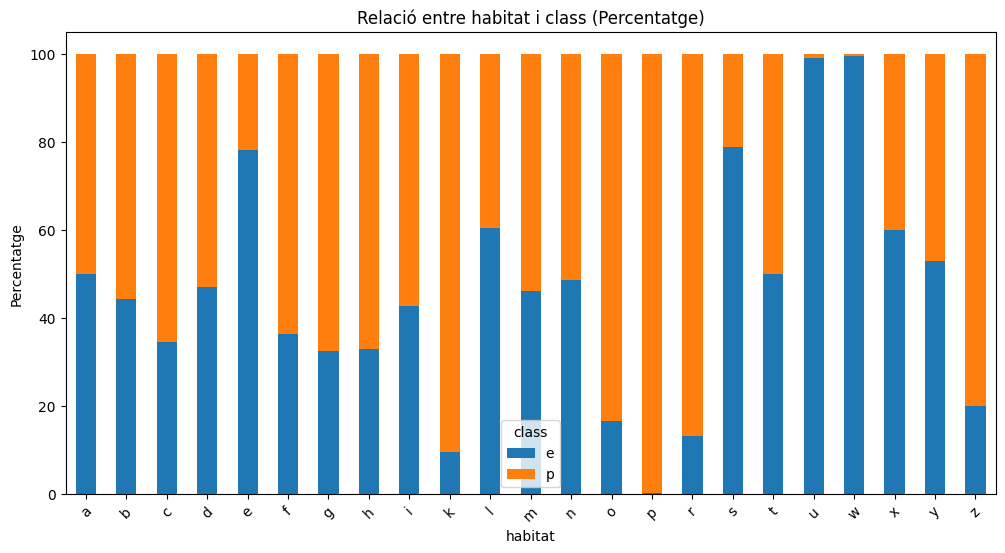

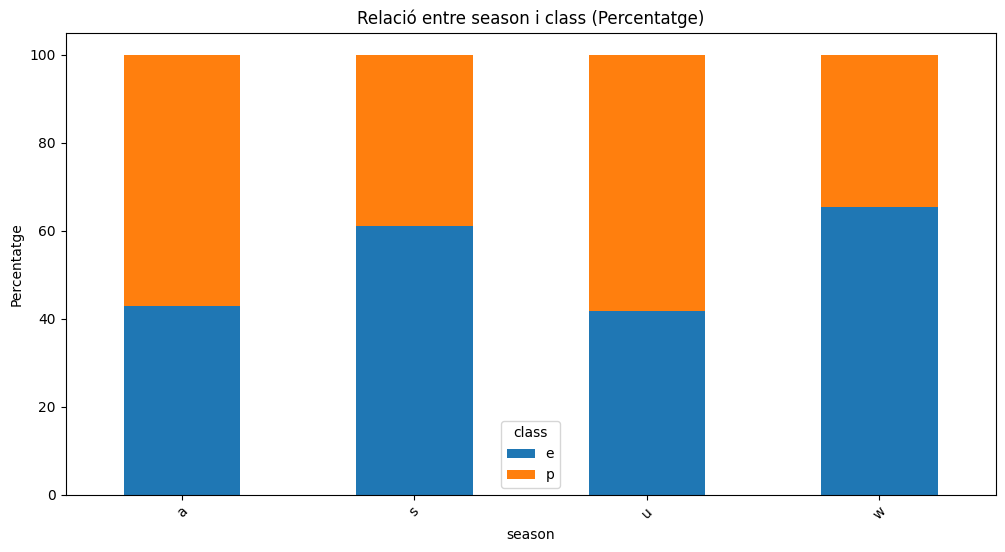

In [ ]:
def plot_categorical_target_relation(df, target_column):
    for column in object_columns:
        if column != target_column and column in df.columns:
            plt.figure(figsize=(12, 6))
            cross_tab = pd.crosstab(df[column], df[target_column], normalize='index') * 100
            cross_tab.plot(kind='bar', stacked=True, ax=plt.gca())
            plt.title(f'Relació entre {column} i {target_column} (Percentatge)')
            plt.xticks(rotation=45)
            plt.ylabel('Percentatge')
            plt.legend(title=target_column)
            plt.show()
            print("")
plot_categorical_target_relation(filtered_df, 'class')
plt.close()

A simple vista podem veure que hi han valors de característiques les quals només pertanyen pràcticament a la classe 'p' com pot ser veil-color = n, e, u que corresponen a venenosos, de la classe 'e' en canvi, no hi ha cap valor en cap característica que ens digui sí o sí que aquell bolet és comestible, però tenim alguns valors, que són majoritariament de la classe 'e' com per exemple stem-root = 'b'.

# Relació de variables numèriques amb el target

Al igual que hem fet amb les caracteristiques categoriques ara analitzarem la relació entre les caracteristiques continues i el target.

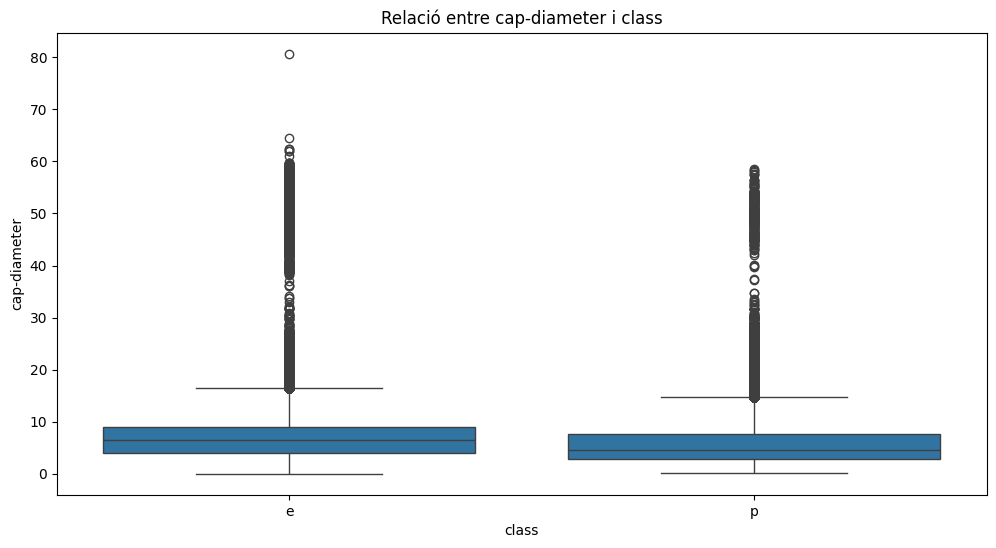

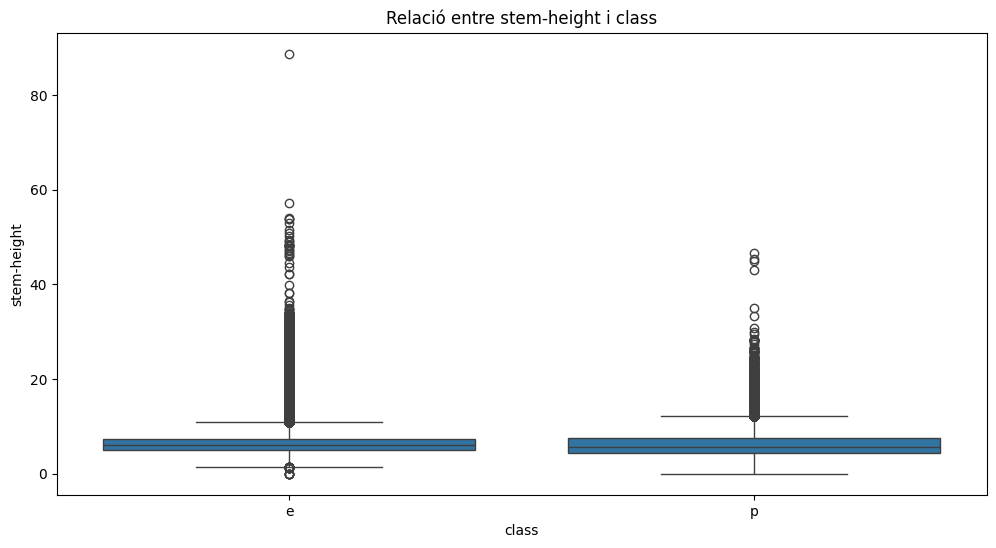

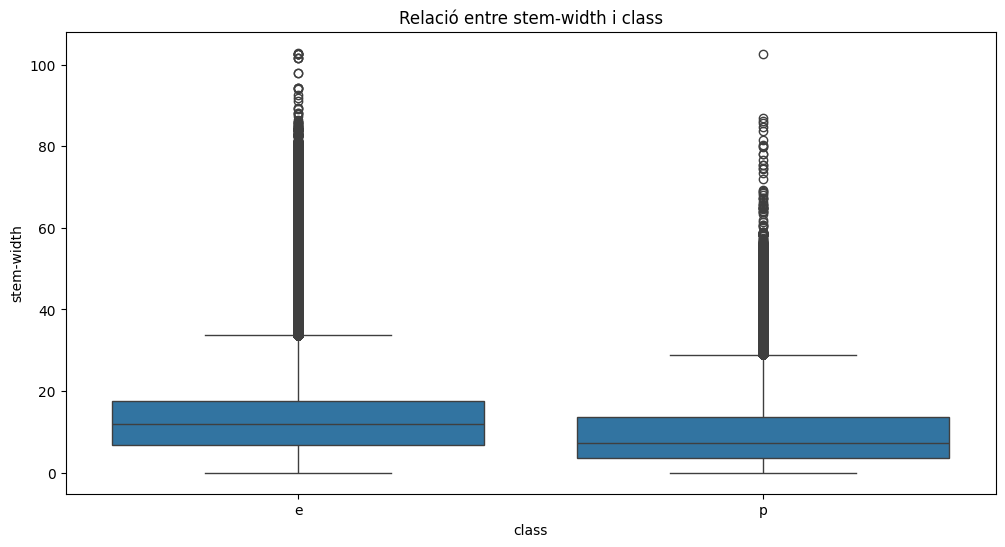

In [ ]:
def plot_numeric_target_relation(df, target_column):
    for column in numeric_columns:
        if column != target_column and column in df.columns:
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=target_column, y=column, data=df)
            plt.title(f'Relació entre {column} i {target_column}')
            plt.show()
            print("")

plot_numeric_target_relation(filtered_df, 'class')
plt.close()

Tot i que hi han petites diferencies no podem indicar si és comestible o no només mirant les relacions amb aquestes tres caracteristiques individualment.

# Tractament d'outliers

Abans de res, dividim el dataset en train i test per evitar trobar-nos en una situació de 'data leakage'.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis=1), df['class'], test_size=0.3, random_state=42)

Com hem dit abans en les variables continues necesitem fer un tractament de valors anomals, per a fer el tractament utilitzarem el mètode del rang interquantil amb un threshold, calculem el quartil inferior i superior, el rang interquantil i creem els límits del domini, si alguna variable supera el límit, utilitzem la funció .clip per ajustar el seu valor al límit inferior o superior depenen del valor.

In [ ]:
def tractar_outliers_train(train, columns, threshold=1.5):
    limits = {}
    df_treated = train
    for column in numeric_columns:
      Q1 = df_treated[column].quantile(0.25)
      Q3 = df_treated[column].quantile(0.75)
      IQR = Q3 - Q1
      limit_inferior = Q1 - threshold * IQR
      limit_superior = Q3 + threshold * IQR
      limits[column] = (limit_inferior, limit_superior)
      df_treated[column] = df_treated[column].clip(limit_inferior, limit_superior)
    return df_treated, limits

def tractar_outliers_test(test, columns, limits):
    df_treated = test
    for column in numeric_columns:
      limit_inferior, limit_superior = limits[column]
      df_treated[column] = df_treated[column].clip(limit_inferior, limit_superior)
    return df_treated

X_train, limits = tractar_outliers_train(X_train, numeric_columns)
X_test = tractar_outliers_test(X_test, numeric_columns, limits)
X_train.describe()
#X_test.describe()

,cap-diameter,stem-height,stem-width
count,935084.000000,935084.000000,935084.000000
mean,6.112694,6.214085,11.026038
std,3.572934,2.246831,7.658481
min,0.030000,0.560000,0.000000
25%,3.310000,4.670000,4.970000
50%,5.750000,5.880000,9.650000
75%,8.230000,7.410000,15.620000
max,15.620000,11.520000,31.620000


# Tractament de valors null

Pel tractament de valors null, primer mirarem quin percentatge de valors tenim a cada característica, si tenim valors molt alts, simplement eliminarem la característica

In [ ]:
def null_percentage(df):
    nulls = df.isnull().sum()
    percentatges = (nulls / len(df)) * 100
    return percentatges

percentatges = null_percentage(X_train).sort_values(ascending=False)
percentatges

,0
veil-type,94.886842
spore-print-color,91.421039
stem-root,88.458477
veil-color,87.921870
stem-surface,63.548595
gill-spacing,40.358895
cap-surface,21.526440
gill-attachment,16.799008
ring-type,4.143160
gill-color,0.003529


Utilitzarem un threshold de 80%, per tant, eliminarem les columnes stem-root, veil-color, spore-print-color i veil-type.

In [ ]:
threshold = 80
columnes_a_eliminar = percentatges[percentatges > threshold].index
X_train = X_train.drop(columns=columnes_a_eliminar)
X_test = X_test.drop(columns=columnes_a_eliminar)

print(X_train.shape)
X_test.shape

(2181861, 16)


(935084, 16)

Per les columnes restants com a punt d'inici utilitzarem la mediana per les columnes numèriques i la moda per les categòriques, posteriorment si els resultats no són satisfactoris utilitzarem altres mètodes com el knn imputer.

In [ ]:
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        moda_train = X_train[column].mode()[0]
        X_train[column].fillna(moda_train, inplace=True)
        X_test[column].fillna(moda_train, inplace=True)
    elif X_train[column].dtype == 'float64':
        mediana_train = X_train[column].median()
        X_train[column].fillna(mediana_train, inplace=True)
        X_test[column].fillna(mediana_train, inplace=True)

<ipython-input-11-254d9838d145>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[column].fillna(mediana_train, inplace=True)
<ipython-input-11-254d9838d145>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [ ]:
print(f"NaNs al dataset train: ", X_train.isna().sum().sum())
print(f"NaNs al dataset test: ", X_test.isna().sum().sum())

NaNs al dataset train:  0
NaNs al dataset test:  0


In [ ]:
X_train.describe()

In [ ]:
ordinal_columns = ['gill-spacing', 'gill-color', 'ring-type']
numeric_columns = ['cap-diameter', 'stem-height', 'stem-width']
nominal_columns = [col for col in X_train.columns if col not in ordinal_columns and col not in numeric_columns]
ordinal_columns = [col for col in X_train.columns if col not in nominal_columns and col not in numeric_columns]


def fit_encode_nominals(df_train):
    encoder = OneHotEncoder(sparse_output=True, handle_unknown="ignore")
    temp_train = encoder.fit_transform(df_train[nominal_columns])

    temp_train_df = pd.DataFrame.sparse.from_spmatrix(temp_train, columns=encoder.get_feature_names_out(nominal_columns))

    df_train_transformed = pd.concat([df_train.drop(columns=nominal_columns).reset_index(drop=True), temp_train_df], axis=1)

    return df_train_transformed, encoder, nominal_columns

def transform_nominals(df_test, encoder, nominal_columns):
    temp_test = encoder.transform(df_test[nominal_columns])

    temp_test_df = pd.DataFrame.sparse.from_spmatrix(temp_test, columns=encoder.get_feature_names_out(nominal_columns))

    df_test_transformed = pd.concat([df_test.drop(columns=nominal_columns).reset_index(drop=True), temp_test_df], axis=1)

    return df_test_transformed

def fit_encode_ordinals(df_train):
    ordinal_encoders = {}
    for col in ordinal_columns:
        if col in df_train.columns:
            encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            df_train[col] = encoder.fit_transform(df_train[[col]]).ravel()
            ordinal_encoders[col] = encoder
    return df_train, ordinal_encoders

def transform_ordinals(df_test, ordinal_encoders):
    for col, encoder in ordinal_encoders.items():
        if col in df_test.columns:
            df_test[col] = encoder.transform(df_test[[col]]).ravel()
    return df_test

def fit_encode_target(y_train):
    target_encoder = LabelEncoder()
    y_train_encoded = target_encoder.fit_transform(y_train)
    return y_train_encoded, target_encoder

def transform_target(y_test, target_encoder):
    y_test_encoded = target_encoder.transform(y_test)
    return y_test_encoded

# 1. Nominal
X_train, nominal_encoder, nominal_cols = fit_encode_nominals(X_train)
X_test = transform_nominals(X_test, nominal_encoder, nominal_cols)

# 2. Ordinal
X_train, ordinal_encoders = fit_encode_ordinals(X_train)
X_test = transform_ordinals(X_test, ordinal_encoders)

# 3. Target
y_train, target_encoder = fit_encode_target(y_train)
y_test = transform_target(y_test, target_encoder)



# Eliminació de columnes no rellevants (s'ha de canviar)

In [ ]:
X_train
X_train_columns = X_train.columns
X_train_columns

import pandas as pd
X_train['class'] = y_train
def remove_low_correlation_features(df, target_column, threshold=0.1):
    correlations = df.corr()[target_column]
    low_correlation_columns = correlations[abs(correlations) < threshold].index.tolist()
    df_filtered = df.drop(columns=low_correlation_columns)

    return df_filtered, low_correlation_columns

X_train, columns_to_delete = remove_low_correlation_features(X_train, 'class')

In [ ]:
X_train = X_train.drop('class', axis=1)
X_test = X_test.drop(columns_to_delete, axis=1)
print(X_train_columns)
X_train.columns

,cap-diameter,gill-spacing,gill-color,stem-height,stem-width,ring-type,cap-shape_a,cap-shape_b,cap-shape_c,cap-shape_d,...,habitat_t,habitat_u,habitat_w,habitat_x,habitat_y,habitat_z,season_a,season_s,season_u,season_w
0,1.97,2.0,12.0,5.88,2.64,5.0,0,1.0,0,0,...,0,0,0,0,0,0,0,1.0,0,0
1,1.56,2.0,6.0,5.29,1.70,5.0,0,0,1.0,0,...,0,0,0,0,0,0,0,0,1.0,0
2,0.67,2.0,12.0,3.73,0.93,5.0,0,0,0,0,...,0,0,0,0,0,0,1.0,0,0,0
3,7.06,2.0,12.0,5.63,8.83,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0
4,3.83,2.0,6.0,6.58,4.65,5.0,0,1.0,0,0,...,0,0,0,0,0,0,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2181856,7.67,2.0,19.0,8.70,17.26,14.0,0,0,0,0,...,0,0,0,0,0,0,1.0,0,0,0
2181857,9.88,2.0,19.0,5.10,25.29,5.0,0,0,0,0,...,0,0,0,0,0,0,1.0,0,0,0
2181858,15.62,2.0,21.0,6.20,31.62,5.0,0,0,0,0,...,0,0,0,0,0,0,1.0,0,0,0
2181859,6.29,2.0,6.0,5.35,7.71,5.0,0,0,0,0,...,0,0,0,0,0,0,1.0,0,0,0


# Escalar dades

In [ ]:
import gc
gc.collect()
def scale_and_encode(X_train, X_test):
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    del X_train
    gc.collect()

    X_test_scaled = scaler.transform(X_test)
    del X_test
    gc.collect()

    return X_train_scaled, X_test_scaled
X_train, X_test = scale_and_encode(X_train, X_test)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print(f"Decision tree: {dt.score(X_test, y_test)}")

In [ ]:
# No funciona arreglar, utilitza el total de columnes en comptes de les restants d'eliminar per correlació

importances = dt.feature_importances_
feature_names = X_train_columns.tolist()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
rt = RandomForestClassifier(random_state = 42)
rt.fit(X_train, y_train)
print(f"Random forest: {rt.score(X_test, y_test)}")

In [ ]:
# No funciona arreglar

importances = rt.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

NameError: name 'rt' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score

dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier(random_state=42)

models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model
}

print("Cross-Validation Scores:")
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
    print(f"{model_name}: {cv_scores.mean():.4f} accuracy with a standard deviation of {cv_scores.std():.4f}")

for model in models.values():
    model.fit(X_train, y_train)

print("\nTest Set Scores:")
for model_name, model in models.items():
    test_score = model.score(X_test, y_test)
    print(f"{model_name}: {test_score:.4f}")

Cross-Validation Scores:
Logistic Regression: 1.0000 accuracy with a standard deviation of 0.0000
Support Vector Machine: 1.0000 accuracy with a standard deviation of 0.0000
Decision Tree: 1.0000 accuracy with a standard deviation of 0.0000
Random Forest: 1.0000 accuracy with a standard deviation of 0.0000

Test Set Scores:
Logistic Regression: 1.0000
Support Vector Machine: 1.0000
Decision Tree: 1.0000
Random Forest: 1.0000
